# ***Tech Challenge - Fase 2***

## **Grupo 38**


Leadnro Braga Alves

Rodrigo Mitsuo Yoshida

Roberto Yukio Ihara

## O Problema

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base. Para isso utilize a base de dados contida no site da investing e selecione o período “diário”, com o intervalo de tempo que achar adequado. Você precisará demonstrar para o time de investimentos:
- O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
- Justificar a técnica utilizada;
- Atingir uma acuracidade adequada (acima de 70%).

## Análise Exploratória dos Dados

Bibliotecas

In [1658]:
import pandas as pd
import numpy as np 
import warnings
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.stattools import acf, pacf
from dateutil.relativedelta import relativedelta
import streamlit as st

from statsforecast import StatsForecast
from statsforecast.models import Naive, AutoARIMA
#from statsmodels.tsa.arima.model import ARIMA
#from pmdarima.arima import auto_arima
#from sklearn.metrics import mean_squared_error,mean_absolute_error
#from math import sqrt

from datetime import datetime

from statsmodels.tsa.stattools import adfuller

#from fbprophet import Prophet
from prophet import Prophet
#from prophet.plot import plot_plotly, plot_components_plotly

warnings.filterwarnings("ignore")

Vamos utilizar o yfinance que é uma biblioteca do Python que permite a extração e análise de dados financeiros do Yahoo Finance.

Parametros

In [1659]:
ticker = '^BVSP'
inicio = '1900-01-01'
#fim = date.today()
fim = '2024-01-31' 
window = 12

data_inicio_modelo = '2021-01-31'

# Converte as strings para datas
fim_date = datetime.strptime(fim, '%Y-%m-%d')
data_inicio_modelo_date = datetime.strptime(data_inicio_modelo, '%Y-%m-%d')

# Calcula a diferença entre as datas
total_dias = (fim_date - data_inicio_modelo_date).days

treino_dias = int(total_dias * 0.90)
teste_dias = int(total_dias * 0.10)

In [1660]:


#pega um mês antes da data passada para preencher o primeiros dias do ano.
#inicio_anterior = pd.to_datetime(inicio)
#inicio_anterior = inicio_anterior - relativedelta(months=1)


#carrega informacoes do IBovespa
#df = yf.download(ticker, start=inicio_anterior, end=fim)
df = yf.download(ticker, start=inicio, end=fim)

#seleciona somente a coluna de fechamento
df_close = df[['Close']]

df_close.head()

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
1993-04-27,24.500000
1993-04-28,24.299999
1993-04-29,23.700001
1993-04-30,24.100000
1993-05-03,24.100000


Como o Ibovespa possui somente cotação dos dias úteis vamos preencher os dias faltantes com a última cotação conhecida.

In [1661]:
#Criar datas faltantes repetindo o valor ultima data conhecida
df_close_last = df_close
df_close_last = df_close_last.resample('D').ffill()
df_close_last = df_close_last[df_close_last.index >= inicio]


'''
#Cria coluna ID e coloca a coluna como indice
df_close_resample = df_close_last.copy()

df_close_resample['id'] = range(1, len(df_close_resample) + 1)
df_close_resample.reset_index(inplace=True)
df_close_resample = df_close_resample.set_index('id')

df_close_resample['Date'] = pd.to_datetime(df_close_resample['Date'], format='%Y-%m-%d')

#renomear colunas do dataframe
df_close_resample.columns = ['ds', 'y']
df_close_resample['unique_id'] = 'IBOV'


df_close_resample.head(20)
'''

"\n#Cria coluna ID e coloca a coluna como indice\ndf_close_resample = df_close_last.copy()\n\ndf_close_resample['id'] = range(1, len(df_close_resample) + 1)\ndf_close_resample.reset_index(inplace=True)\ndf_close_resample = df_close_resample.set_index('id')\n\ndf_close_resample['Date'] = pd.to_datetime(df_close_resample['Date'], format='%Y-%m-%d')\n\n#renomear colunas do dataframe\ndf_close_resample.columns = ['ds', 'y']\ndf_close_resample['unique_id'] = 'IBOV'\n\n\ndf_close_resample.head(20)\n"

## Verificando se a série é estacionária

Plotando o gráfio Data x Valor

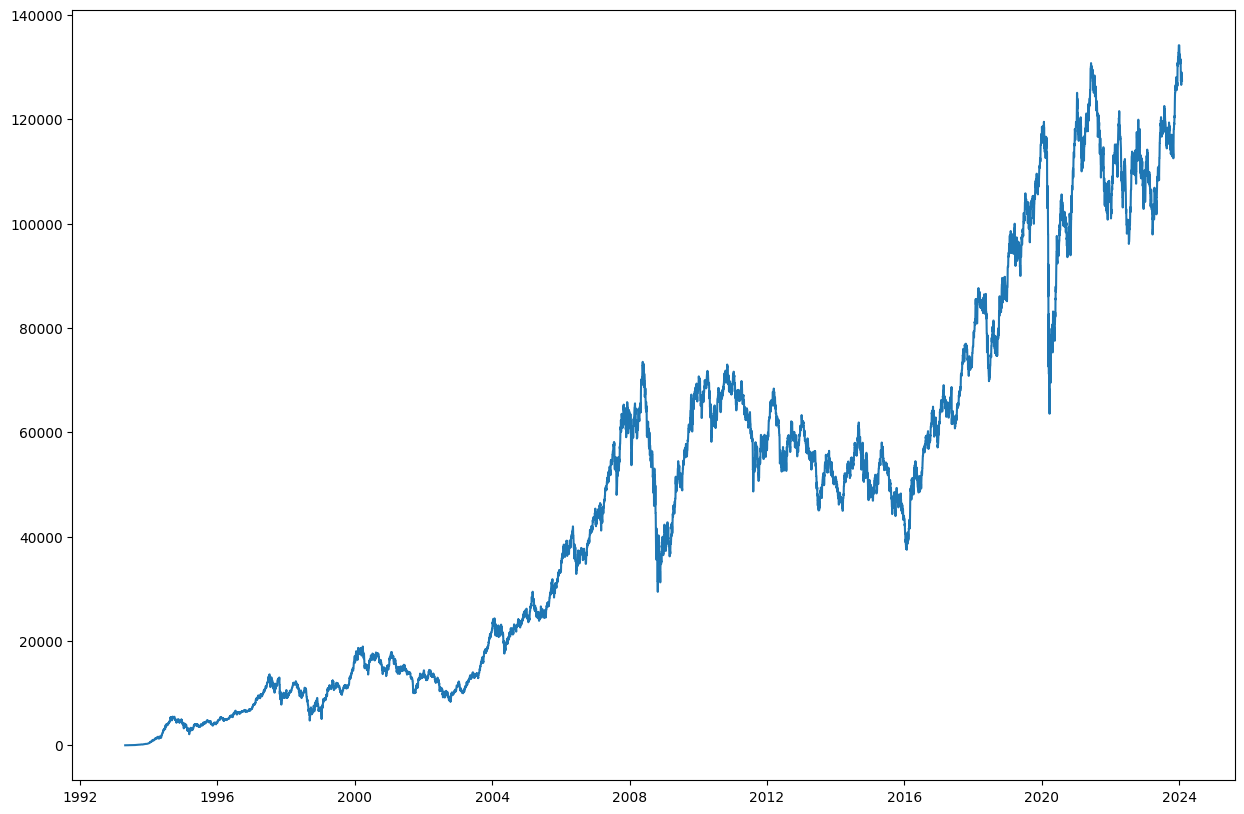

In [1662]:
plt.figure(figsize=(15, 10))
plt.plot(df_close_last.index, df_close_last.Close)

Decomposição

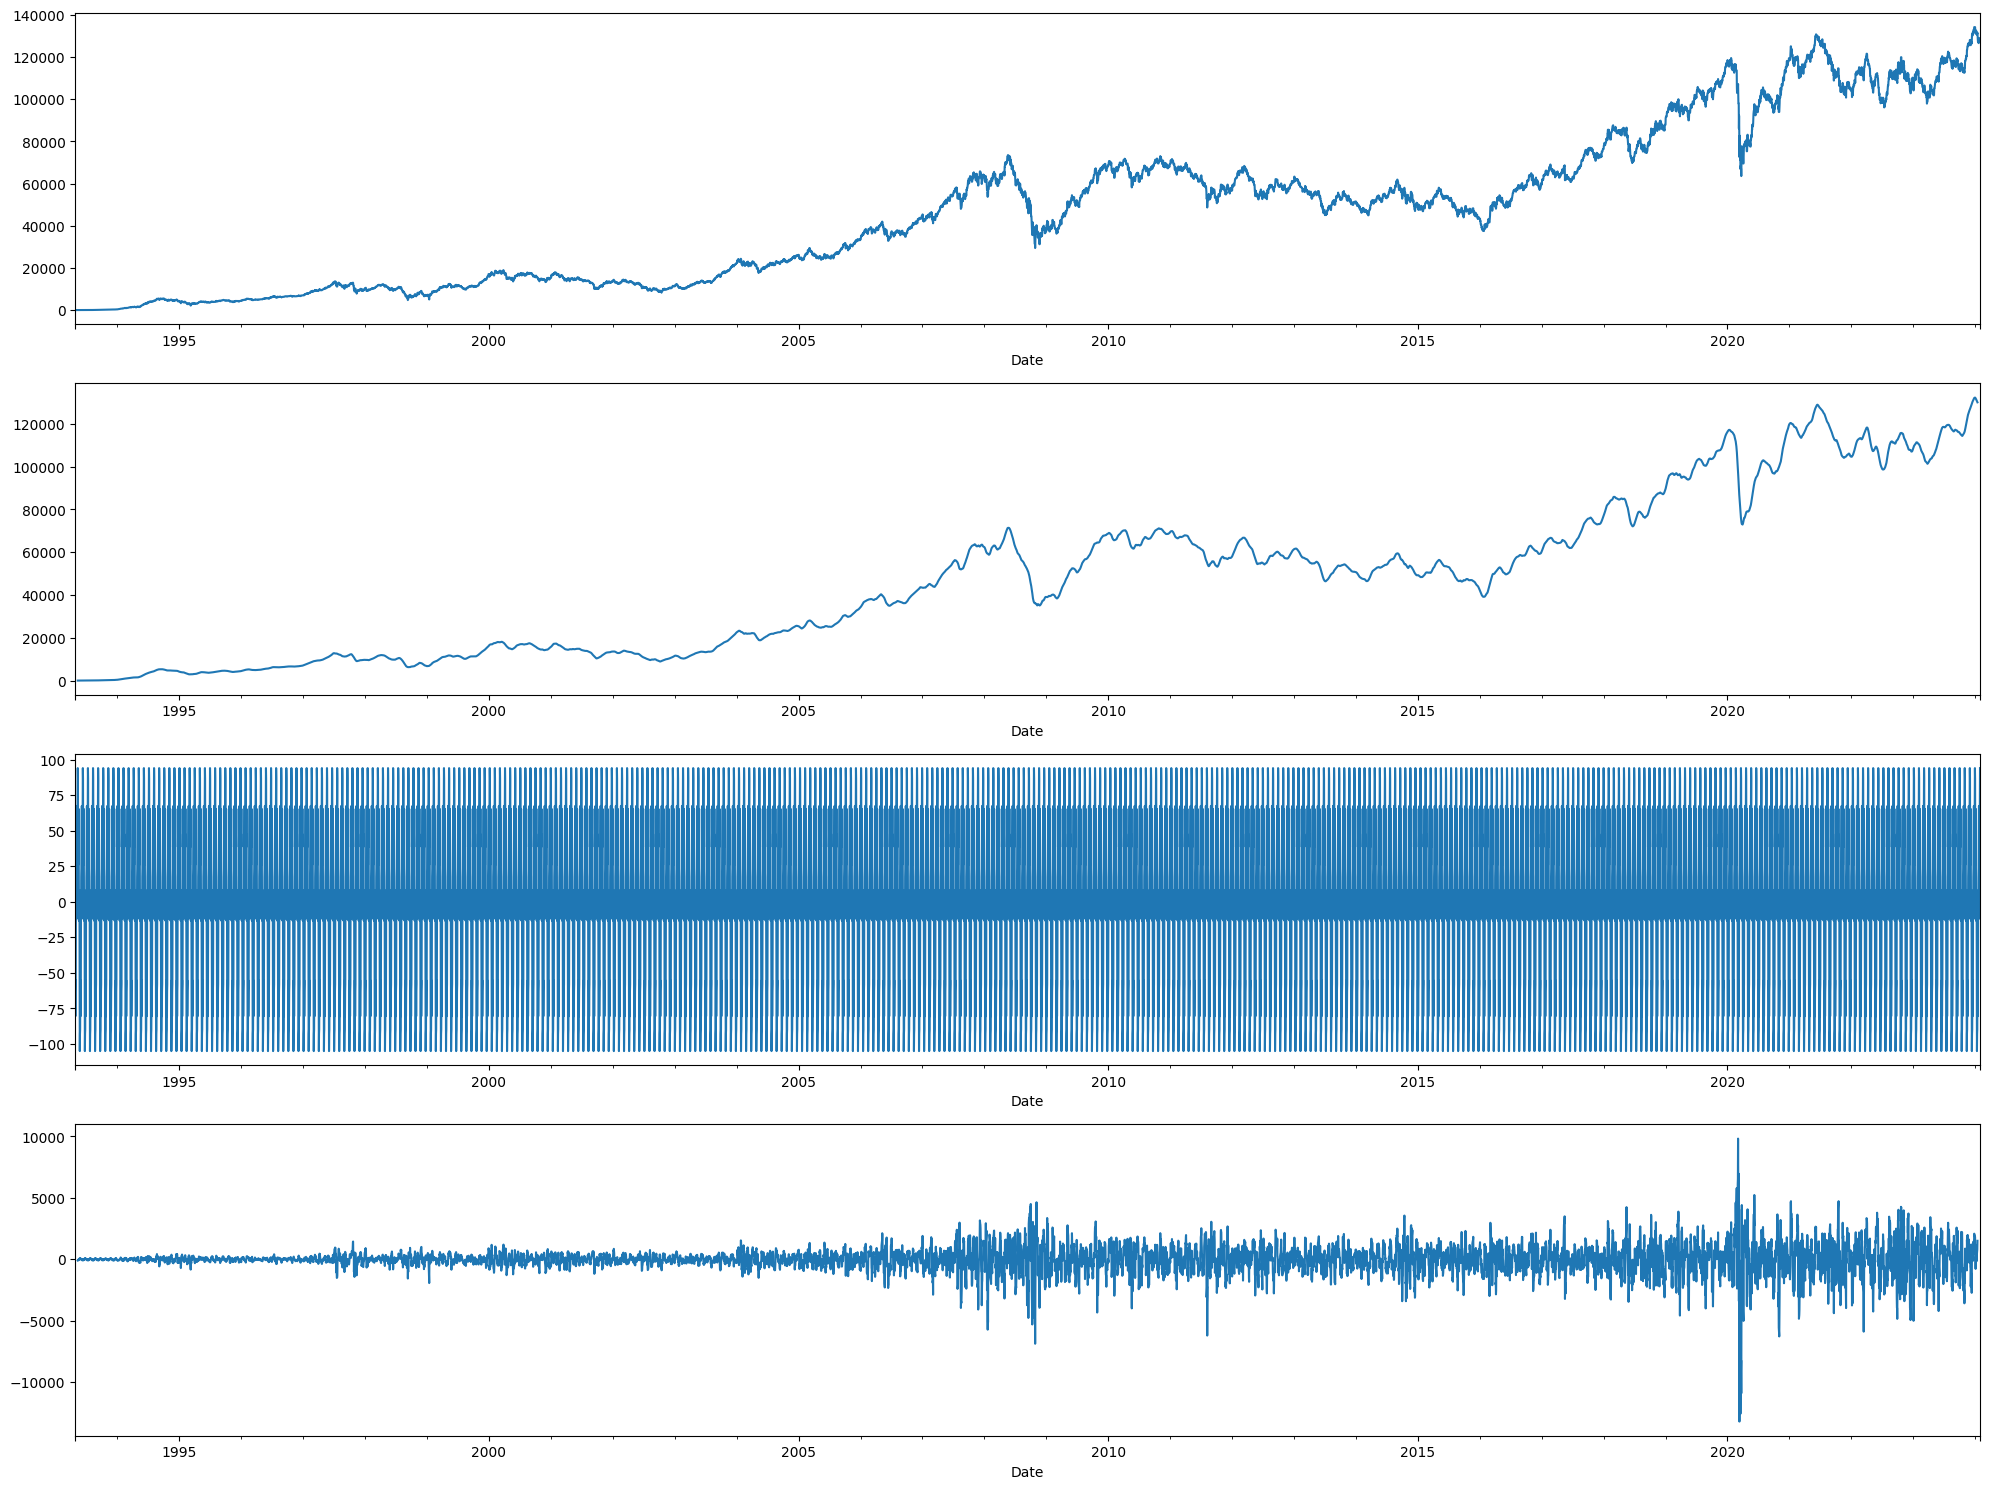

In [1663]:
#Decomposicao
decomposition = seasonal_decompose(df_close_last , model='additive', period=30)

# Plota o resultado da decomposição
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,15))
decomposition.observed.plot(ax=ax1)
decomposition.trend.plot(ax=ax2)
decomposition.seasonal.plot(ax=ax3)
decomposition.resid.plot(ax=ax4)
plt.tight_layout()

# Usa st.pyplot() para renderizar a figura no Streamlit
#st.pyplot(fig)


Plotagem de Rolling Statistics

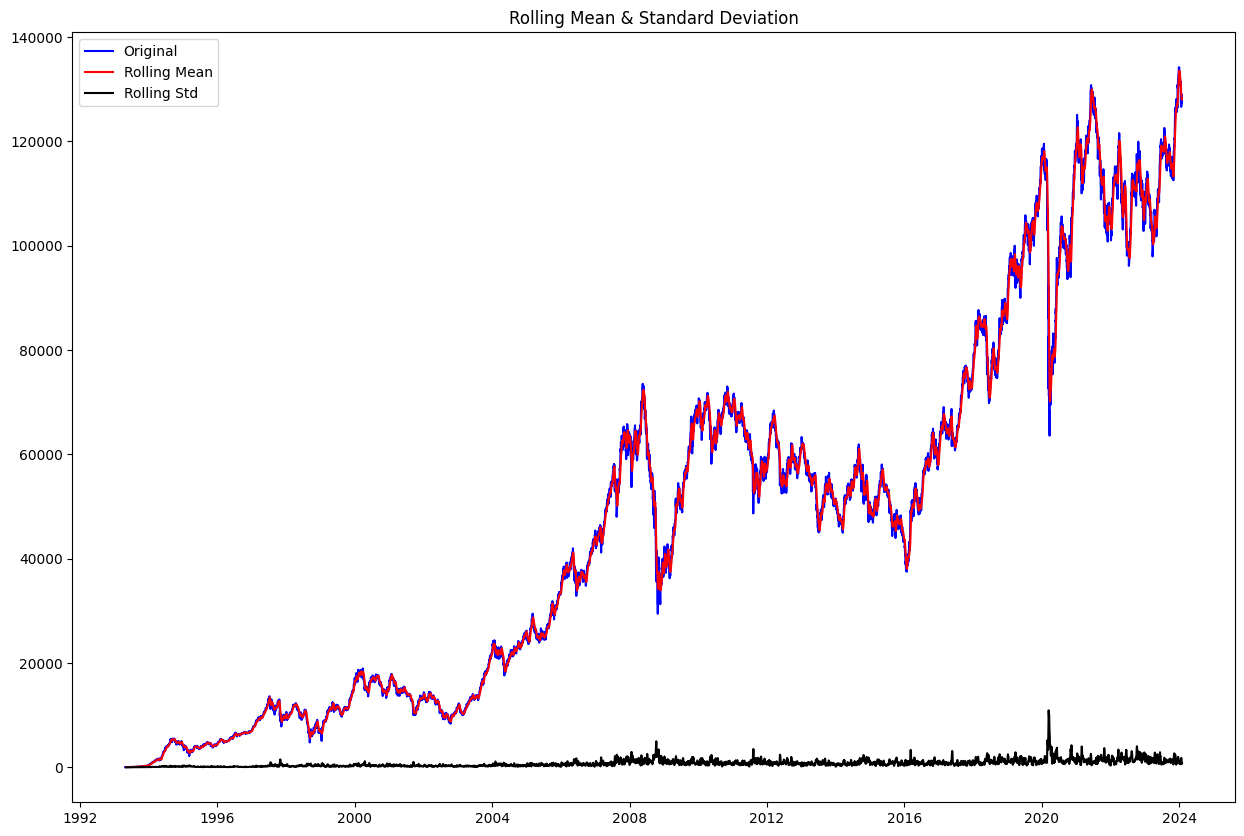

In [1664]:
#Rolling statistics - Técnica Visual
rolmean = df_close_last.rolling(window=window).mean().dropna()
rolstd = df_close_last.rolling(window=window).std().dropna()

#Plot rolling statistics:
plt.figure(figsize=(15,10))
orig = plt.plot(df_close_last, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Embora a variação de desvio padrão seja pequena, a média está claramente aumentando com o tempo e isto não é uma característica de série estacionária. Além disso, a estatística de teste é muito mais do que os valores críticos. Note que os valores assinalados devem ser comparados e não os valores absolutos.

Dickey-Fuller teste

In [1665]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_close_last, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                    -0.414503
p-value                            0.907649
#Lags Used                        15.000000
Number of Observations Used    11220.000000
Critical Value (1%)               -3.430933
Critical Value (5%)               -2.861798
Critical Value (10%)              -2.566907
dtype: float64


## Transformar em estacionária

Uma das primeiras manobras para reduzir a tendência pode ser transformação. Por exemplo, neste caso, podemos ver claramente que existe uma tendência positiva significativa. Assim, podemos aplicar transformação que penaliza os valores maiores mais do que valores menores. 

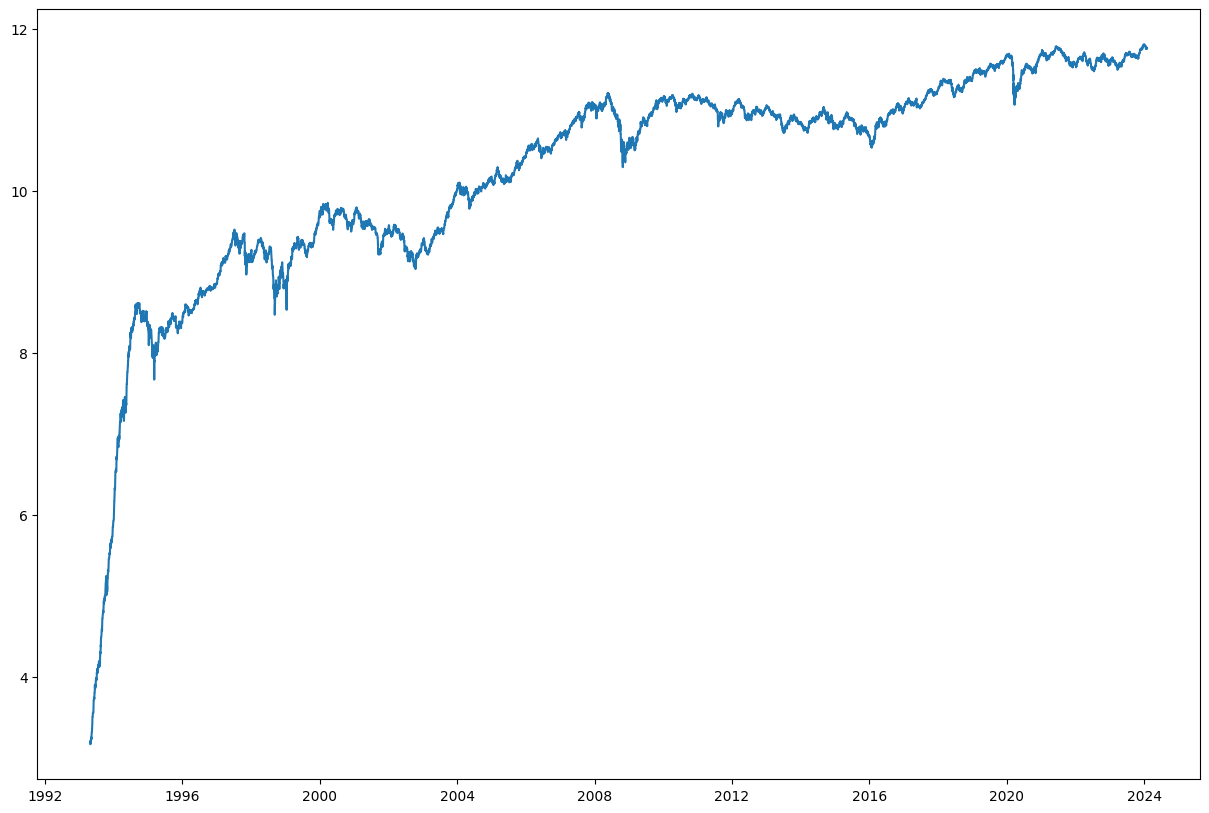

In [1666]:
ts_log = np.log(df_close_last)
plt.figure(figsize=(15,10))
plt.plot(ts_log)

Média Móvel

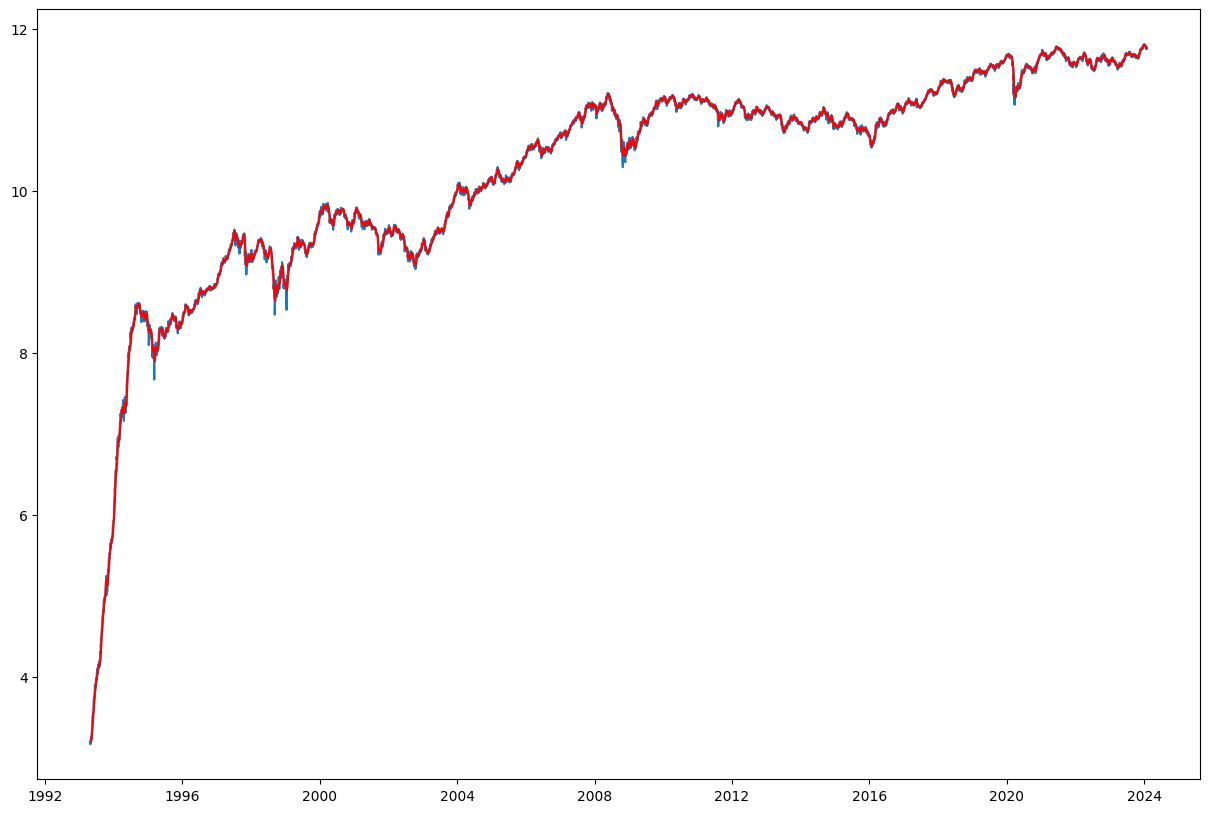

In [1667]:
moving_avg = ts_log.rolling(window=window).mean()
plt.figure(figsize=(15,10))
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

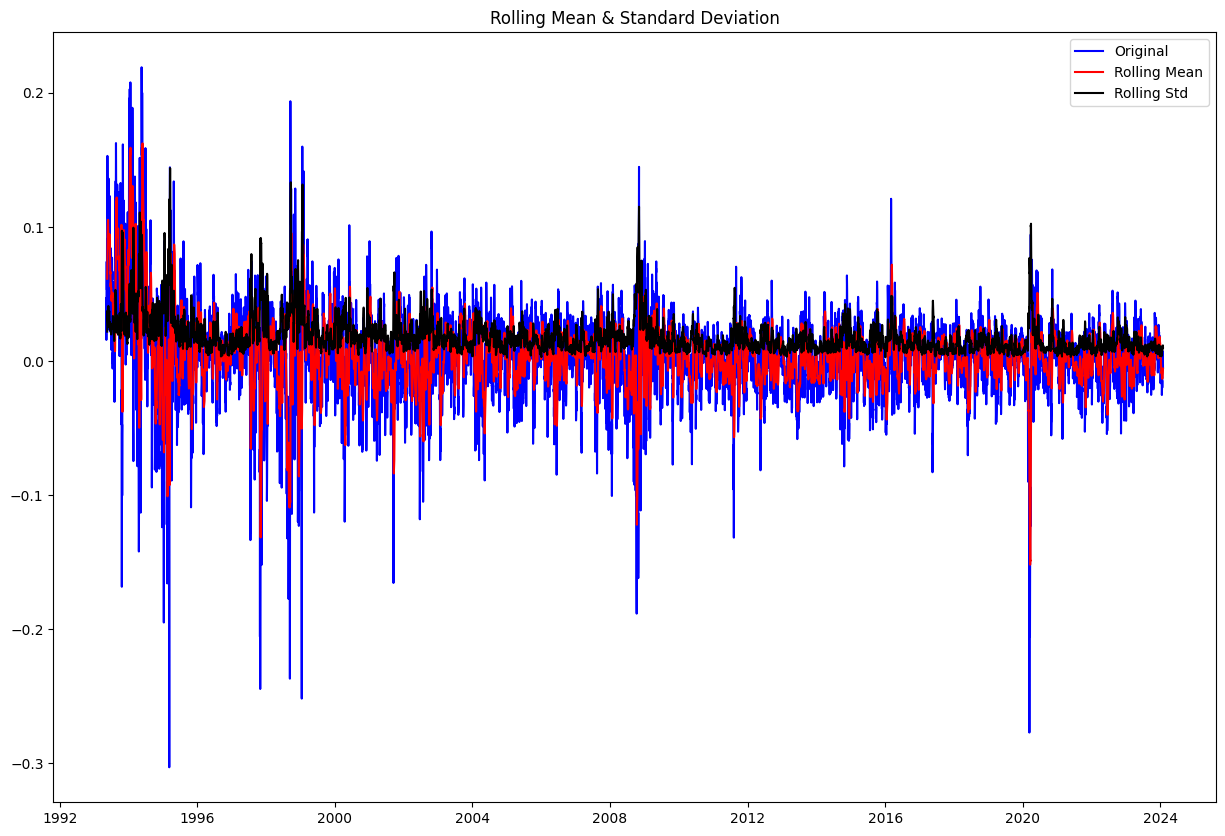

In [1668]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)

#Rolling statistics
rolmean = ts_log_moving_avg_diff.rolling(window=window).mean().dropna()
rolstd = ts_log_moving_avg_diff.rolling(window=window).std().dropna()

#Plot rolling statistics:
plt.figure(figsize=(15,10))
orig = plt.plot(ts_log_moving_avg_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [1669]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ts_log_moving_avg_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.217035e+01
p-value                        1.425488e-22
#Lags Used                     3.600000e+01
Number of Observations Used    1.118800e+04
Critical Value (1%)           -3.430935e+00
Critical Value (5%)           -2.861798e+00
Critical Value (10%)          -2.566908e+00
dtype: float64


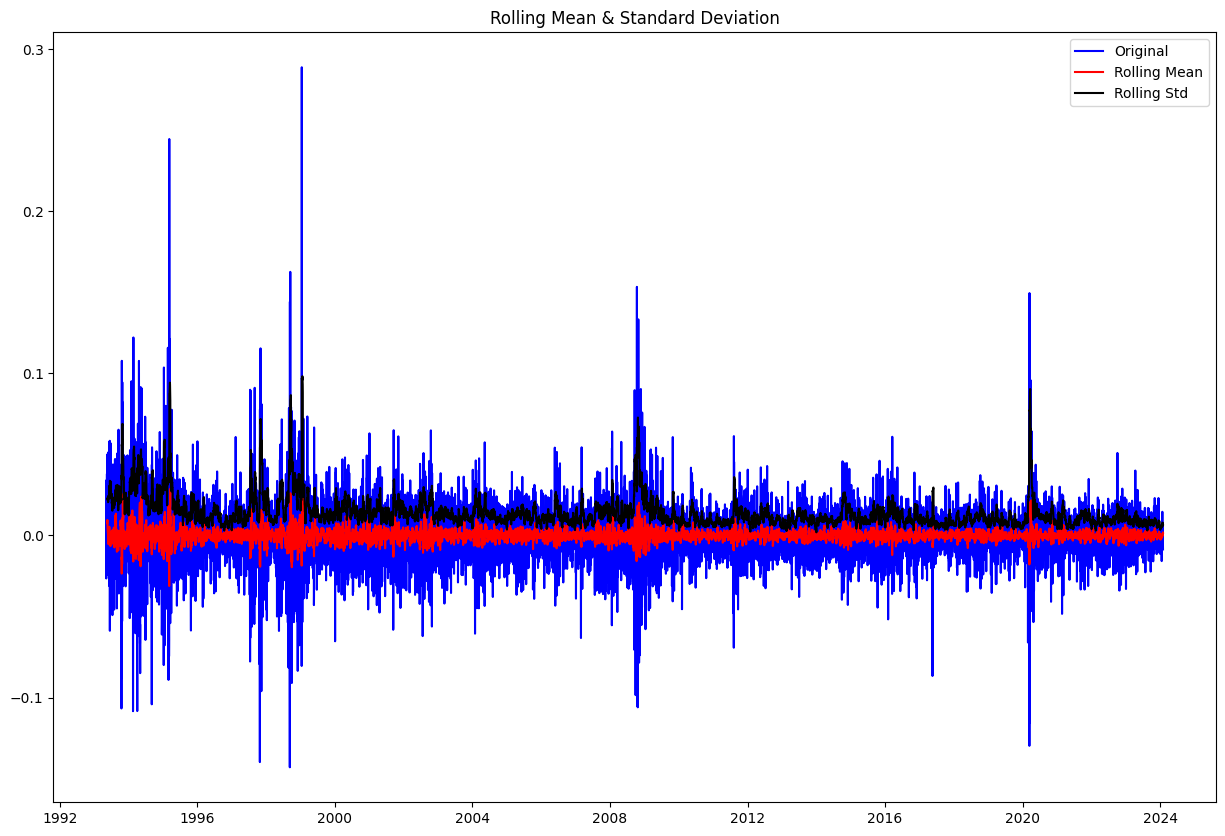

In [1670]:
#Deixar mais estacionária - Derivada
df_diff = ts_log_moving_avg_diff.diff(1)

df_diff.dropna(inplace=True)

#Rolling statistics
rolmean = df_diff.rolling(window=window).mean().dropna()
rolstd = df_diff.rolling(window=window).std().dropna()

#Plot rolling statistics:
plt.figure(figsize=(15,10))
orig = plt.plot(df_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [1671]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -25.883107
p-value                            0.000000
#Lags Used                        40.000000
Number of Observations Used    11183.000000
Critical Value (1%)               -3.430935
Critical Value (5%)               -2.861798
Critical Value (10%)              -2.566908
dtype: float64


## Modelos

In [1672]:
def wmape(y_true, y_pred):
  #return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()
  return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))


In [1673]:
'''
#renomear o campo date para ds, campo close para y e criar o campo unique_id
df_fechamento_n_estacionaria = df_close_last.copy()
df_fechamento_n_estacionaria['id'] = range(1, len(df_fechamento_n_estacionaria) + 1)
df_fechamento_n_estacionaria.reset_index(inplace=True)
df_fechamento_n_estacionaria = df_fechamento_n_estacionaria.set_index('id')
df_fechamento_n_estacionaria['Date'] = pd.to_datetime(df_fechamento_n_estacionaria['Date'], format='%Y-%m-%d')
df_fechamento_n_estacionaria.columns = ['ds', 'y']
df_fechamento_n_estacionaria['unique_id'] = 'IBOV'

df_modelo_prophet = df_fechamento_n_estacionaria.copy()
'''

"\n#renomear o campo date para ds, campo close para y e criar o campo unique_id\ndf_fechamento_n_estacionaria = df_close_last.copy()\ndf_fechamento_n_estacionaria['id'] = range(1, len(df_fechamento_n_estacionaria) + 1)\ndf_fechamento_n_estacionaria.reset_index(inplace=True)\ndf_fechamento_n_estacionaria = df_fechamento_n_estacionaria.set_index('id')\ndf_fechamento_n_estacionaria['Date'] = pd.to_datetime(df_fechamento_n_estacionaria['Date'], format='%Y-%m-%d')\ndf_fechamento_n_estacionaria.columns = ['ds', 'y']\ndf_fechamento_n_estacionaria['unique_id'] = 'IBOV'\n\ndf_modelo_prophet = df_fechamento_n_estacionaria.copy()\n"

In [1674]:
#renomear o campo date para ds, campo close para y e criar o campo unique_id
df_fechamento_n_estacionaria = df_close.copy()
df_fechamento_n_estacionaria['id'] = range(1, len(df_fechamento_n_estacionaria) + 1)
df_fechamento_n_estacionaria.reset_index(inplace=True)
df_fechamento_n_estacionaria = df_fechamento_n_estacionaria.set_index('id')
df_fechamento_n_estacionaria['Date'] = pd.to_datetime(df_fechamento_n_estacionaria['Date'], format='%Y-%m-%d')
df_fechamento_n_estacionaria.columns = ['ds', 'y']
df_fechamento_n_estacionaria['unique_id'] = 'IBOV'

df_modelo_prophet = df_fechamento_n_estacionaria.copy()

In [1675]:
#renomear o campo date para ds, campo close para y e criar o campo unique_id
df_fechamento_estacionaria = df_diff.copy()
#df_fechamento_estacionaria = ts_log_moving_avg_diff.copy()
df_fechamento_estacionaria['id'] = range(1, len(df_fechamento_estacionaria) + 1)
df_fechamento_estacionaria.reset_index(inplace=True)
df_fechamento_estacionaria = df_fechamento_estacionaria.set_index('id')
df_fechamento_estacionaria.columns = ['ds', 'y']
df_fechamento_estacionaria['unique_id'] = 'IBOV'

df_modelo = df_fechamento_estacionaria.copy()

In [1676]:
# Dividindo os dados em treino e teste
'''
treino = df_modelo[(df_modelo['ds'] >= '2023-01-01') & (df_modelo['ds'] < '2024-01-01')]
teste = df_modelo[(df_modelo['ds'] >= '2024-01-01') & (df_modelo['ds'] <= '2024-01-10')]
h = len(teste.index)
'''


treino = df_modelo[-(treino_dias + teste_dias):-teste_dias]
teste = df_modelo[-teste_dias:]
h = len(teste.index)

In [1677]:
'''
treino_prophet = df_modelo_prophet[(df_modelo_prophet['ds'] >= '2015-01-01') & (df_modelo_prophet['ds'] < '2024-01-01')]
teste_prophet = df_modelo_prophet[(df_modelo_prophet['ds'] >= '2024-01-01') & (df_modelo_prophet['ds'] <= '2024-01-10')]
h_prophet = len(teste_prophet.index)
'''

treino_prophet = df_modelo_prophet[-(treino_dias + teste_dias):-teste_dias]
teste_prophet = df_modelo_prophet[-teste_dias:]
h_prophet = len(teste_prophet.index)


In [1678]:
min_date = treino['ds'].min()
max_date = treino['ds'].max()

print('Menor data:', min_date)
print('Maior data:', max_date)

Menor data: 2021-02-01 00:00:00
Maior data: 2023-10-13 00:00:00


Modelo Base Navi

WMAPE: 210.20%


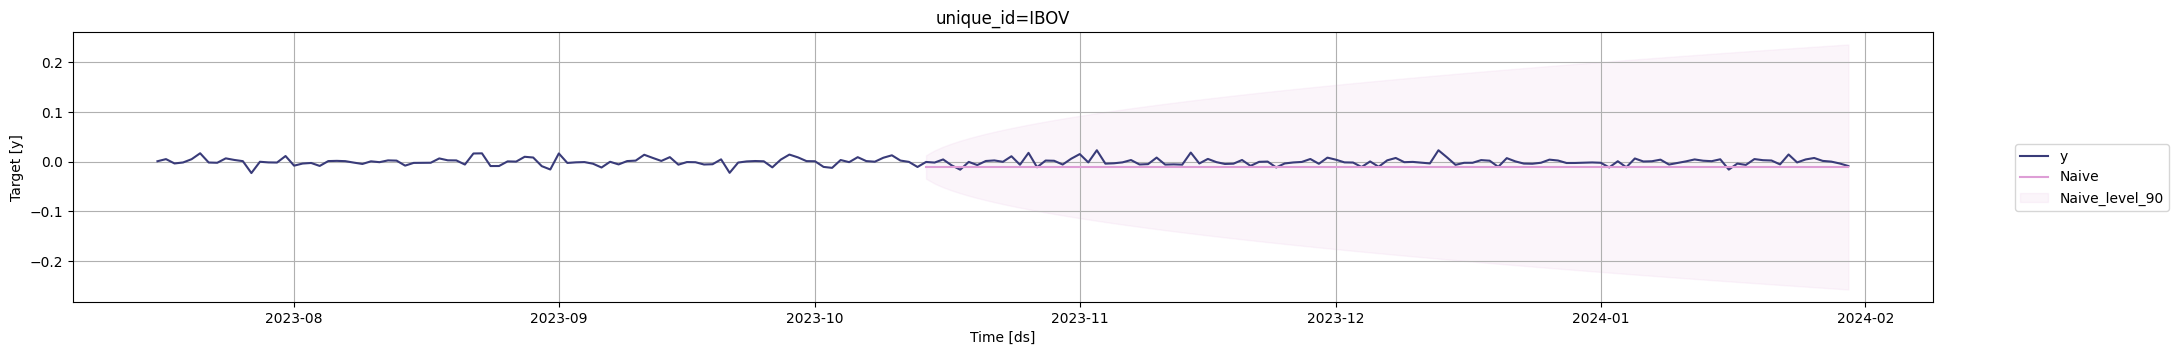

In [1679]:
model1 = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model1.fit(treino)

forecast_df1 = model1.predict(h=h, level=[90])
forecast_df1 = forecast_df1.reset_index().merge(teste, on=['ds', 'unique_id'], how='left')

wmape1 = wmape(forecast_df1['y'].values, forecast_df1['Naive'].values)
print(f"WMAPE: {wmape1:.2%}")

model1.plot(treino, forecast_df1, level=[90], unique_ids=['IBOV'],engine ='matplotlib', max_insample_length=90)

AutoARIMA

WMAPE: 100.01%


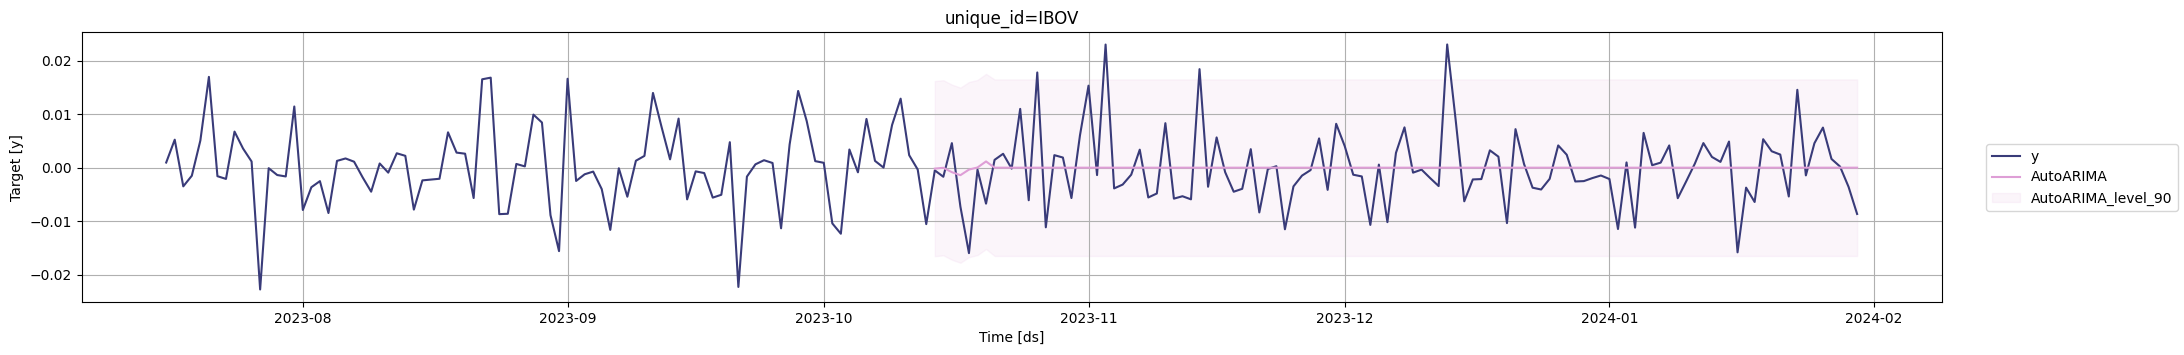

In [1680]:
model2 = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
model2.fit(treino)

forecast_df2 = model2.predict(h=h, level=[90])
forecast_df2 = forecast_df2.reset_index().merge(teste, on=['ds', 'unique_id'], how='left')

wmape2 = wmape(forecast_df2['y'].values, forecast_df2['AutoARIMA'].values)
print(f"WMAPE: {wmape2:.2%}")

model2.plot(treino, forecast_df2, level=[90], unique_ids=['IBOV'],engine ='matplotlib', max_insample_length=90)

Prophet

17:48:54 - cmdstanpy - INFO - Chain [1] start processing
17:48:54 - cmdstanpy - INFO - Chain [1] done processing


WMAPE: 4.52%


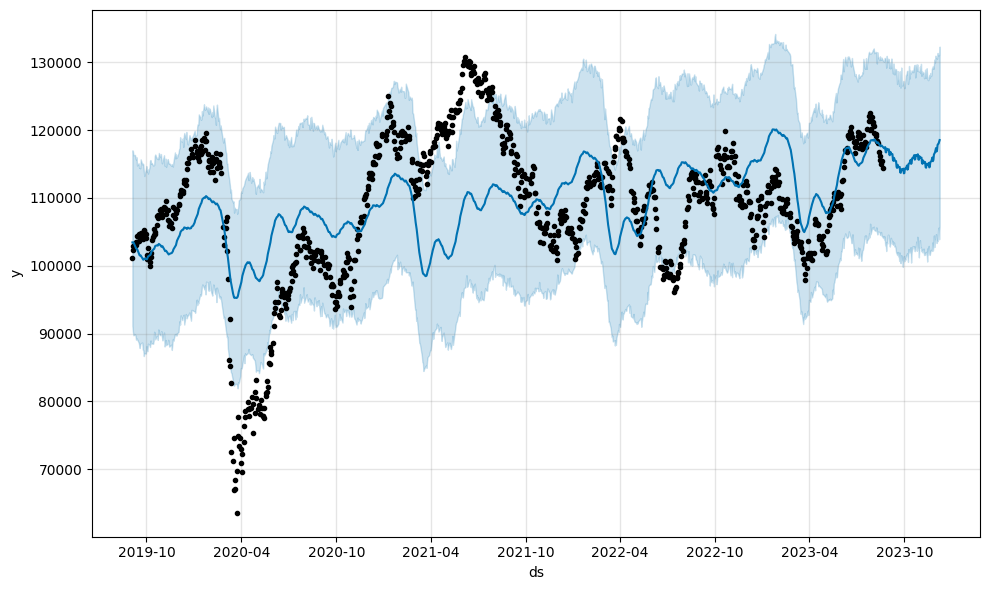

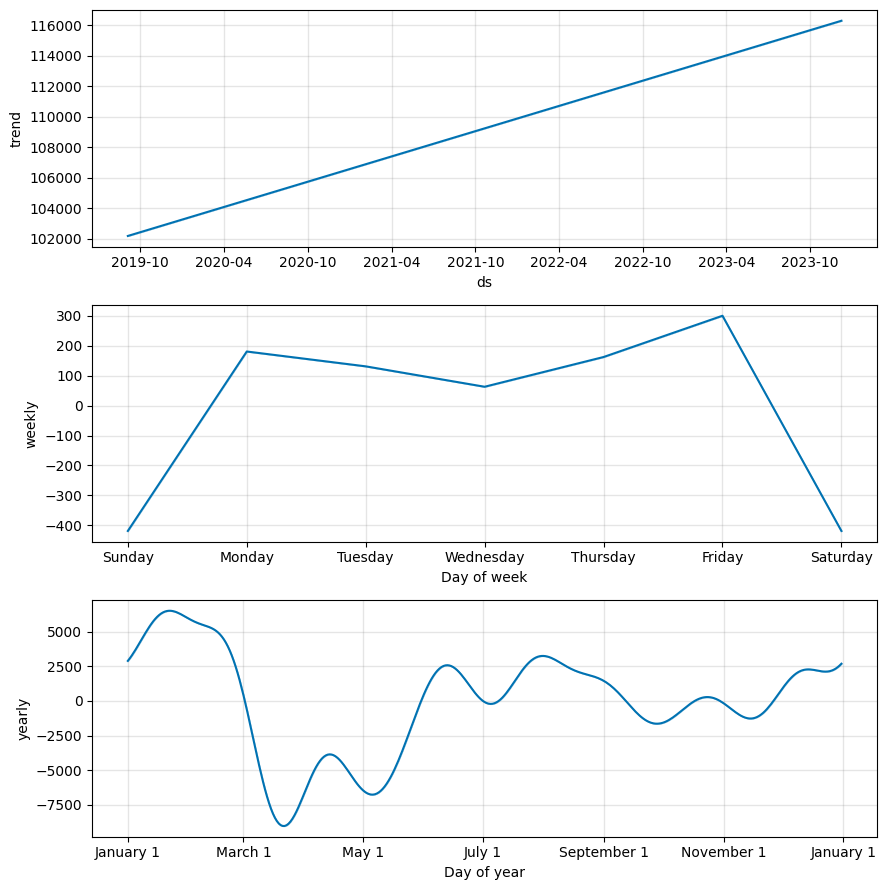

In [1681]:
model3 = Prophet(changepoint_prior_scale= 0.001, seasonality_prior_scale= 0.01)
model3.fit(treino_prophet)


future = model3.make_future_dataframe(periods=h_prophet)
#future.tail()

forecast3 = model3.predict(future)
#forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# fazendo previsões com os dados de teste
test_forecast = model3.predict(teste_prophet)
# olhando os resultados das previsões com os dados de teste
#test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

forecast_df = test_forecast.reset_index().merge(teste_prophet, on=['ds'], how='left')


wmape3 = wmape(forecast_df['y'], forecast_df['yhat'])
print(f"WMAPE: {wmape3:.2%}")

fig1 = model3.plot(forecast3)

fig2 = model3.plot_components(forecast3)




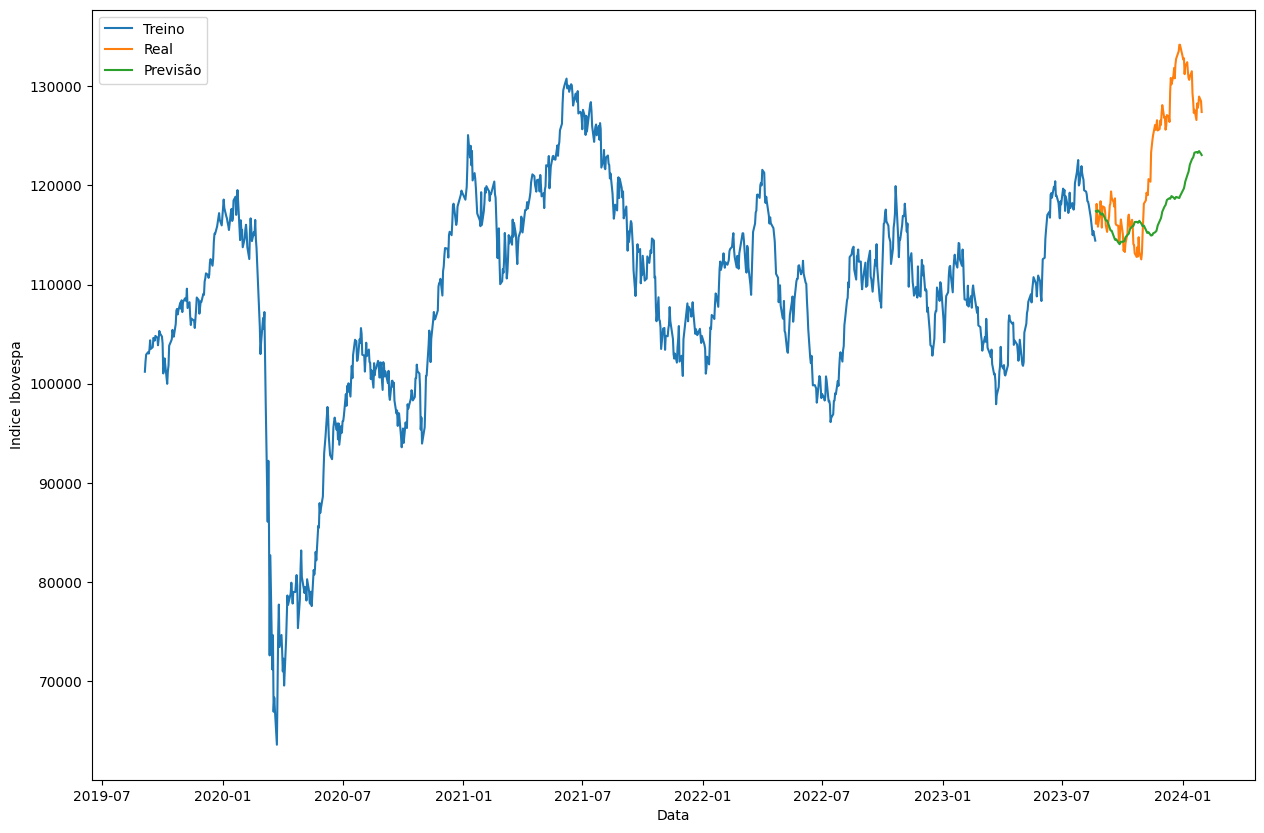

In [1682]:
plt.figure(figsize=(15, 10))

sns.lineplot(
    data = treino_prophet,
    x='ds',
    y='y',
    label='Treino'
)
sns.lineplot(
    data = forecast_df,
    x='ds',
    y='y',
    label='Real' 
)
sns.lineplot(
    data = forecast_df,
    x='ds',
    y='yhat',
    label='Previsão'
)

# Define os nomes dos eixos
plt.xlabel('Data')
plt.ylabel('Indice Ibovespa')

plt.show()

In [1683]:
a = forecast_df[['ds', 'y', 'yhat']]
a['dif'] = np.abs((1-(a['y'] / a['yhat']))) * 100
a

,ds,y,yhat,dif
0,2023-08-22,116156.0,117410.565002,1.068528
1,2023-08-23,118135.0,117311.329142,0.702124
2,2023-08-24,117026.0,117380.942825,0.302385
3,2023-08-25,115837.0,117488.976902,1.406070
4,2023-08-28,117121.0,117265.464259,0.123194
...,...,...,...,...
104,2024-01-24,127816.0,123274.546578,3.684016
105,2024-01-25,128169.0,123357.445423,3.900498
106,2024-01-26,128967.0,123463.495593,4.457596
107,2024-01-29,128503.0,123180.125828,4.321212


Cross-Validation

In [1684]:
from prophet.diagnostics import cross_validation, performance_metrics

# Cross-validation
df_cv = cross_validation(model3, initial='730 days', period='180 days', horizon = '365 days')

# Avaliação das métricas de desempenho
df_p = performance_metrics(df_cv)
print(df_p.head())

  0%|          | 0/2 [00:00<?, ?it/s]17:48:55 - cmdstanpy - INFO - Chain [1] start processing
17:48:56 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  3.20it/s]17:48:56 - cmdstanpy - INFO - Chain [1] start processing
17:48:56 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


  horizon           mse         rmse          mae      mape     mdape  \
0 36 days  6.761273e+07  8222.696097  6051.733682  0.052713  0.041635   
1 37 days  7.262392e+07  8521.967116  6226.580955  0.054066  0.038793   
2 38 days  7.868504e+07  8870.459013  6461.868300  0.055917  0.038793   
3 39 days  7.862434e+07  8867.036700  6458.400212  0.055924  0.038793   
4 40 days  7.828112e+07  8847.661860  6407.254578  0.055481  0.038368   

      smape  coverage  
0  0.054571  0.836735  
1  0.056220  0.816327  
2  0.058374  0.795918  
3  0.058382  0.795918  
4  0.057951  0.795918  


Hyperparameter Tuning

In [1685]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import numpy as np

# Suponha que df seja seu DataFrame com 'ds' e 'y'

# Definir o espaço de hiperparâmetros
param_grid = { 
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Variáveis para armazenar os resultados
best_params = None
best_mae = float('inf')

# Loop para Grid Search
for cps in param_grid['changepoint_prior_scale']:
    for sps in param_grid['seasonality_prior_scale']:
        
        # Configurar o modelo com um conjunto de hiperparâmetros
        m = Prophet(changepoint_prior_scale=cps, seasonality_prior_scale=sps)
        m.fit(treino_prophet)
        
        # Cross-validation
        df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
        
        # Calcular métricas de desempenho
        df_p = performance_metrics(df_cv)
        mae = df_p['mae'].mean()
        
        # Atualizar os melhores parâmetros, se necessário
        if mae < best_mae:
            best_mae = mae
            best_params = {'changepoint_prior_scale': cps, 'seasonality_prior_scale': sps}

print(f'Melhores parâmetros: {best_params}')
print(f'Melhor MAE: {best_mae}')

17:48:57 - cmdstanpy - INFO - Chain [1] start processing
17:48:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]17:48:57 - cmdstanpy - INFO - Chain [1] start processing
17:48:57 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  3.04it/s]17:48:57 - cmdstanpy - INFO - Chain [1] start processing
17:48:57 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  2.86it/s]
17:48:58 - cmdstanpy - INFO - Chain [1] start processing
17:48:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]17:48:58 - cmdstanpy - INFO - Chain [1] start processing
17:48:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  3.27it/s]17:48:59 - cmdstanpy - INFO - Chain [1] start processing
17:48:59 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  3.23it/s]
17:49:00 - cmdstanpy - INFO - Chain [1] start processing
17:49:00 

100%|██████████| 2/2 [00:00<00:00,  2.77it/s]
17:49:04 - cmdstanpy - INFO - Chain [1] start processing
17:49:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]17:49:05 - cmdstanpy - INFO - Chain [1] start processing
17:49:05 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  2.96it/s]17:49:05 - cmdstanpy - INFO - Chain [1] start processing
17:49:05 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  2.82it/s]
17:49:06 - cmdstanpy - INFO - Chain [1] start processing
17:49:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]17:49:06 - cmdstanpy - INFO - Chain [1] start processing
17:49:06 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  2.79it/s]17:49:07 - cmdstanpy - INFO - Chain [1] start processing
17:49:07 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  2.87it/s]
17:49:07 - cmdstanpy

Melhores parâmetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}
Melhor MAE: 8255.041432624692
